<a href="https://colab.research.google.com/github/darshdadhich/parkinson/blob/main/Parkinson's_Disease_Science_Fair_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ails-lab/ntua-parkinson-dataset

Cloning into 'ntua-parkinson-dataset'...
remote: Enumerating objects: 42113, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 42113 (delta 0), reused 4 (delta 0), pack-reused 42104 (from 1)
Receiving objects: 100% (42113/42113), 2.14 GiB | 21.35 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (44019/44019), done.


In [2]:
!pip install imblearn

# DAT Model

In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from PIL import Image

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}" )

Using device: cpu


In [5]:
# Set path for dataset
data_dir = "/content/ntua-parkinson-dataset"

# Load images and labels from the dataset
def load_images_and_labels(data_dir, target_size=(224, 224)):
    images = []
    labels = []

    for label_folder in ['PD Patients', 'Non PD Patients']:
        label_path = os.path.join(data_dir, label_folder)
        label = 1 if label_folder == 'PD Patients' else 0

        for person_folder in os.listdir(label_path):
            person_path_fol = os.path.join(label_path, person_folder, '0.DAT/')
            if os.path.isdir(person_path_fol):
                for person_path in os.listdir(person_path_fol):
                    person_path = os.path.join(person_path_fol, person_path)
                    if os.path.exists(person_path):
                        for img_file in os.listdir(person_path):
                            img_path = os.path.join(person_path, img_file)
                            img = cv2.imread(img_path)
                            if img is not None:
                                img = cv2.resize(img, target_size)
                                images.append(img)
                                labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    print(f"Loaded {len(images)} images.")
    print(f"Label distribution: {np.unique(labels, return_counts=True)}")
    return images, labels

images, labels = load_images_and_labels(data_dir)

# Check the loaded dataset
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Loaded 920 images.
Label distribution: (array([0, 1]), array([330, 590]))
Images shape: (920, 224, 224, 3)
Labels shape: (920,)


In [6]:
# Split the dataset into training and validation sets, ensuring both classes are present
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
print(f"Class distribution in y_train: {np.unique(y_train, return_counts=True)}")
print(f"Class distribution in y_val: {np.unique(y_val, return_counts=True)}")

# Convert the images to PyTorch tensors
X_train_tensor = torch.tensor(X_train).permute(0, 3, 1, 2).float()  # Convert (N, H, W, C) to (N, C, H, W)
X_val_tensor = torch.tensor(X_val).permute(0, 3, 1, 2).float()  # Convert (N, H, W, C) to (N, C, H, W)

# Convert the labels to PyTorch tensors of type long
y_train_tensor = torch.tensor(y_train).long()
y_val_tensor = torch.tensor(y_val).long()

# Apply SMOTE to address class imbalance
X_train_flat = X_train_tensor.reshape(X_train_tensor.shape[0], -1).numpy()  # Flatten to (N, 3*224*224)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_flat, y_train)

# Convert back to PyTorch tensors
X_resampled = torch.tensor(X_resampled).float().reshape(-1, 3, 224, 224)  # Reshape to (N, 3, 224, 224)
y_resampled = torch.tensor(y_resampled).long()

# Create DataLoader for batching and shuffling
train_dataset = torch.utils.data.TensorDataset(X_resampled, y_resampled)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Class distribution in y_train: (array([0, 1]), array([264, 472]))
Class distribution in y_val: (array([0, 1]), array([ 66, 118]))


In [7]:

# Model setup (ResNet50)
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2048, 1)
)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


In [8]:
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Training dataset size: 944
Validation dataset size: 184


In [38]:
from sklearn.metrics import precision_score, recall_score
# Loss and optimizer with regularization (L2 regularization via weight_decay)
pos_weight = torch.tensor([2.0]).to(device)  # Lower weight for Non-PD to prioritize PD
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Binary cross-entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Regularization with weight_decay

# Training loop
num_epochs = 2
threshold = 0.88  # Adjust threshold to reduce false positives
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    precision_total = 0
    recall_total = 0

    for images_batch, labels_batch in train_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device).float()

        optimizer.zero_grad()
        outputs = model(images_batch)
        loss = criterion(outputs.squeeze(), labels_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Apply sigmoid and threshold
        predicted = (torch.sigmoid(outputs) > threshold).float()
        correct += (predicted.squeeze() == labels_batch).sum().item()
        total += labels_batch.size(0)

        # Calculate precision and recall
        y_true = labels_batch.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        precision_total += precision_score(y_true, y_pred)
        recall_total += recall_score(y_true, y_pred)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_precision = precision_total / len(train_loader)
    train_recall = recall_total / len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    precision_total = 0
    recall_total = 0

    with torch.no_grad():
        for images_batch, labels_batch in val_loader:
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device).float()

            outputs = model(images_batch)
            loss = criterion(outputs.squeeze(), labels_batch)
            val_loss += loss.item()

            # Apply sigmoid and threshold
            predicted = (torch.sigmoid(outputs) > threshold).float()
            correct += (predicted.squeeze() == labels_batch).sum().item()
            total += labels_batch.size(0)

            # Calculate precision and recall
            y_true = labels_batch.cpu().numpy()
            y_pred = predicted.cpu().numpy()
            precision_total += precision_score(y_true, y_pred)
            recall_total += recall_score(y_true, y_pred)

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_precision = precision_total / len(val_loader)
    val_recall = recall_total / len(val_loader)

    # Print statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

if epoch == num_epochs - 1:  # On the last epoch, analyze threshold performance
        precision, recall, thresholds = precision_recall_curve(all_y_true, all_y_pred_probs)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        best_threshold_index = f1_scores.argmax()
        best_threshold = thresholds[best_threshold_index]

        print(f"Best threshold based on F1-score: {best_threshold:.2f}")

Epoch [1/2], Train Loss: 0.0360, Train Acc: 99.24%, Train Precision: 0.9952, Train Recall: 0.9908, Val Loss: 0.4523, Val Acc: 89.63%, Val Precision: 0.8762, Val Recall: 0.8796
Epoch [2/2], Train Loss: 0.0117, Train Acc: 99.39%, Train Precision: 0.9940, Train Recall: 0.9957, Val Loss: 0.3281, Val Acc: 92.68%, Val Precision: 0.8921, Val Recall: 1.0000
Best threshold based on F1-score: 0.88


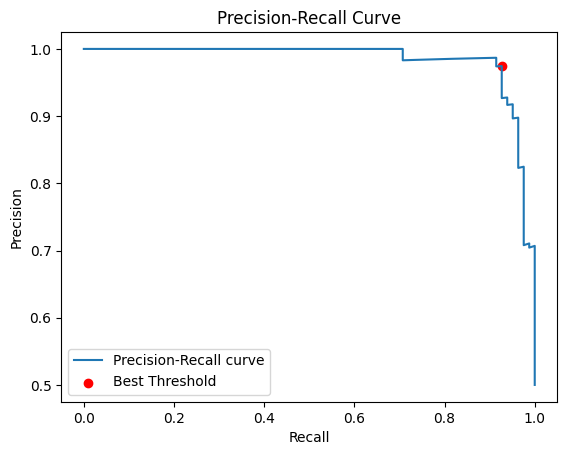

In [39]:
        # Plot Precision-Recall curve
        plt.figure()
        plt.plot(recall, precision, label="Precision-Recall curve")
        plt.scatter(recall[best_threshold_index], precision[best_threshold_index], color="red", label="Best Threshold")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend()
        plt.show()

In [43]:
# Save model
torch.save(model.state_dict(), 'parkinsons_resnet50_dat_final.pth')

# MRI Model

In [11]:
import os
import cv2

def load_mri_images_and_labels(data_dir, target_size=(224, 224), max_images_per_class=920):
    """
    Load MRI images and their labels, with an optional limit on the number of images per class.

    Args:
        data_dir (str): Path to the dataset directory.
        target_size (tuple): Desired image size (width, height).
        max_images_per_class (int): Maximum number of images to load per class.

    Returns:
        images (list): List of loaded images.
        labels (list): Corresponding labels for the images.
    """
    images = []
    labels = []

    for label_folder in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_folder)
        if os.path.isdir(label_path):  # Ensure it's a directory
            image_count = 0
            for person_folder in os.listdir(label_path):
                person_path_fol = os.path.join(label_path, person_folder)
                if os.path.isdir(person_path_fol):  # Ensure it's a directory
                    for person_path in os.listdir(person_path_fol):
                        person_path = os.path.join(person_path_fol, person_path)
                        if os.path.isdir(person_path):  # Ensure it's a directory
                            for img_file in os.listdir(person_path):
                                img_path = os.path.join(person_path, img_file)
                                if (
                                    os.path.isfile(img_path)
                                    and img_file.lower().endswith(('.png', '.jpg', '.jpeg'))
                                    and "mpr" in img_file.lower()  # Filter for MRI files
                                ):
                                    if image_count >= max_images_per_class:
                                        break
                                    img = cv2.imread(img_path)
                                    if img is not None:
                                        img = cv2.resize(img, target_size)
                                        images.append(img)
                                        labels.append(label_folder)
                                        image_count += 1
    return images, labels

# Specify your dataset directory
data_dir = '/content/ntua-parkinson-dataset'

# Load MRI images and labels with a limit of 50 images per class
images, labels = load_mri_images_and_labels(data_dir, max_images_per_class=410)

# Check the loaded dataset
print(f"Loaded {len(images)} MRI images with {len(labels)} labels.")


Loaded 820 MRI images with 820 labels.


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import numpy as np
import torch
from torch.utils.data import DataLoader


# Split the dataset into training and validation sets, ensuring class balance
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)
print(f"Class distribution in y_train: {np.unique(y_train, return_counts=True)}")
print(f"Class distribution in y_val: {np.unique(y_val, return_counts=True)}")

# Encode the labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Fit and transform on training labels
y_val_encoded = label_encoder.transform(y_val)  # Transform validation labels

# Convert images to NumPy arrays
X_train_np = np.array(X_train)  # Convert list of arrays to a single NumPy array
X_val_np = np.array(X_val)

# Convert the images to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np).permute(0, 3, 1, 2).float()  # Convert (N, H, W, C) to (N, C, H, W)
X_val_tensor = torch.tensor(X_val_np).permute(0, 3, 1, 2).float()

# Convert the labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train_encoded).long()
y_val_tensor = torch.tensor(y_val_encoded).long()

# Flatten the dataset for SMOTE
X_train_flat = X_train_tensor.reshape(X_train_tensor.shape[0], -1).numpy()

# Apply PCA to reduce dimensionality (optional, helps with memory usage)
pca = PCA(n_components=50)  # Reduce to 50 components
X_train_reduced = pca.fit_transform(X_train_flat)

# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_resampled_reduced, y_resampled = smote.fit_resample(X_train_reduced, y_train_encoded)

# Inverse PCA to reconstruct high-dimensional data
X_resampled_flat = pca.inverse_transform(X_resampled_reduced)
X_resampled = torch.tensor(X_resampled_flat).float().reshape(-1, 3, 224, 224)
y_resampled = torch.tensor(y_resampled).long()

# Create DataLoader for batching and shuffling
train_dataset = torch.utils.data.TensorDataset(X_resampled, y_resampled)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Verify loaders
print(f"Training dataset size after SMOTE: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Class distribution in y_train: (array(['Non PD Patients', 'PD Patients'], dtype='<U15'), array([328, 328]))
Class distribution in y_val: (array(['Non PD Patients', 'PD Patients'], dtype='<U15'), array([82, 82]))
Training dataset size after SMOTE: 656
Validation dataset size: 164


In [13]:

# Model setup (ResNet50)
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2048, 1)
)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Training dataset size: 656
Validation dataset size: 164


In [41]:
from sklearn.metrics import precision_score, recall_score
# Loss and optimizer with regularization (L2 regularization via weight_decay)
pos_weight = torch.tensor([2.0]).to(device)  # Lower weight for Non-PD to prioritize PD
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Binary cross-entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Regularization with weight_decay

# Training loop
num_epochs = 2
threshold = 0.88  # Adjust threshold to reduce false positives
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    precision_total = 0
    recall_total = 0

    for images_batch, labels_batch in train_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device).float()

        optimizer.zero_grad()
        outputs = model(images_batch)
        loss = criterion(outputs.squeeze(), labels_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Apply sigmoid and threshold
        predicted = (torch.sigmoid(outputs) > threshold).float()
        correct += (predicted.squeeze() == labels_batch).sum().item()
        total += labels_batch.size(0)

        # Calculate precision and recall
        y_true = labels_batch.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        precision_total += precision_score(y_true, y_pred)
        recall_total += recall_score(y_true, y_pred)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_precision = precision_total / len(train_loader)
    train_recall = recall_total / len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    precision_total = 0
    recall_total = 0

    with torch.no_grad():
        for images_batch, labels_batch in val_loader:
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device).float()

            outputs = model(images_batch)
            loss = criterion(outputs.squeeze(), labels_batch)
            val_loss += loss.item()

            # Apply sigmoid and threshold
            predicted = (torch.sigmoid(outputs) > threshold).float()
            correct += (predicted.squeeze() == labels_batch).sum().item()
            total += labels_batch.size(0)

            # Calculate precision and recall
            y_true = labels_batch.cpu().numpy()
            y_pred = predicted.cpu().numpy()
            precision_total += precision_score(y_true, y_pred)
            recall_total += recall_score(y_true, y_pred)

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_precision = precision_total / len(val_loader)
    val_recall = recall_total / len(val_loader)

    # Print statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

if epoch == num_epochs - 1:  # On the last epoch, analyze threshold performance
        precision, recall, thresholds = precision_recall_curve(all_y_true, all_y_pred_probs)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        best_threshold_index = f1_scores.argmax()
        best_threshold = thresholds[best_threshold_index]

        print(f"Best threshold based on F1-score: {best_threshold:.2f}")

Epoch [1/2], Train Loss: 0.0002, Train Acc: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Val Loss: 0.4641, Val Acc: 92.68%, Val Precision: 0.8882, Val Recall: 1.0000
Epoch [2/2], Train Loss: 0.0002, Train Acc: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Val Loss: 0.4542, Val Acc: 92.07%, Val Precision: 0.8819, Val Recall: 1.0000
Best threshold based on F1-score: 0.88


In [42]:
# Save model
torch.save(model.state_dict(), 'parkinsons_resnet50_mri_final.pth')

# Parallel Model

In [44]:
import torch
import torch.nn as nn
import torchvision.models as models


# Initialize ResNet50 models for both datasets
resnet50_dat_model = models.resnet50(pretrained=False).to(device)
resnet50_mri_model = models.resnet50(pretrained=False).to(device)

# Modify the fully connected layer if needed (e.g., for classification)
num_classes = 2
resnet50_dat_model.fc = nn.Linear(resnet50_dat_model.fc.in_features, num_classes)
resnet50_mri_model.fc = nn.Linear(resnet50_mri_model.fc.in_features, num_classes)

# Define the ParallelModel class
class ParallelModel(nn.Module):
    def __init__(self, model1, model2):
        super(ParallelModel, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)
        return out1, out2

# Define the DualModel class
class DualModel(nn.Module):
    def __init__(self, model1, model2):
        super(DualModel, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            raise ValueError("Input to DualModel.forward must be a tensor.")

        out1 = self.model1(x)
        out2 = self.model2(x)
        return out1, out2

# Load saved weights into the models (with strict=False to handle missing/unexpected keys)
try:
    resnet50_dat_model.load_state_dict(torch.load('parkinsons_resnet50_dat_final.pth', map_location=device), strict=False)
    resnet50_mri_model.load_state_dict(torch.load('parkinsons_resnet50_mri_final.pth', map_location=device), strict=False)
    print("Models loaded successfully with strict=False.")
except RuntimeError as e:
    print(f"Error loading model weights: {e}")

# Instantiate the DualModel with the ResNet50 models
dual_model = DualModel(model1=resnet50_dat_model, model2=resnet50_mri_model)
dual_model = dual_model.to(device)

# Example forward pass using the DualModel
# Create a dummy input tensor (e.g., a batch of 2 images, each with size 3x224x224)
dummy_input = torch.randn(2, 3, 224, 224).to(device)

# Get predictions from both models
output1, output2 = dual_model(dummy_input)

# Print the output shapes to verify
print("Output from model 1:", output1.shape)
print("Output from model 2:", output2.shape)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-44-54b11de80774>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Models loaded successfully with strict=False.
Output from model 1: torch.Size([2, 2])
Output from model 2: torch.Size([2, 2])


In [45]:
print(type(dual_model.model1))
print(type(dual_model.model2))

<class 'torchvision.models.resnet.ResNet'>
<class 'torchvision.models.resnet.ResNet'>


In [46]:
# Save the state_dict of the parallel model
torch.save(dual_model.state_dict(), 'parkinsons_DAT_MRI_model.pth')


# Confusion Matrix

In [47]:
import torch

# Ensure model is in evaluation mode
dual_model.eval()

# Store true labels and predictions
all_preds = []
all_labels = []

# Iterate through the validation data loader
with torch.no_grad():
    for inputs, labels in val_loader: 
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get predictions from the first model (modify if you use both outputs)
        outputs, _ = dual_model(inputs)  # Or use both outputs if applicable
        _, preds = torch.max(outputs, 1)  # Get the class index with the highest score

        all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to NumPy
        all_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays
y_pred_tensor = np.array(all_preds)
y_val_tensor = np.array(all_labels)


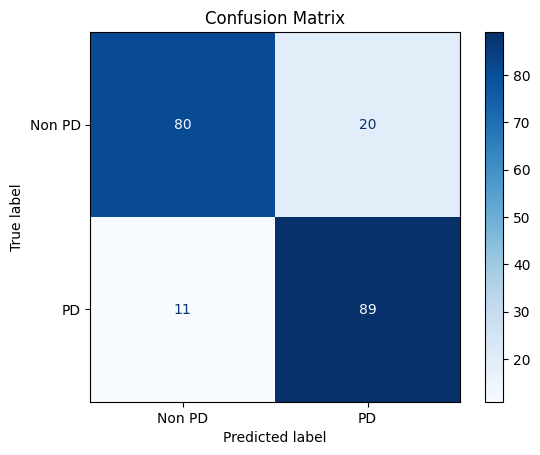

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels = y_val_tensor  # No need to call .numpy() here
predictions = y_pred_tensor  # No need to call .numpy() here

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Normalize the confusion matrix to percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['Non PD', 'PD'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Model Architecture

In [49]:
pip install graphviz

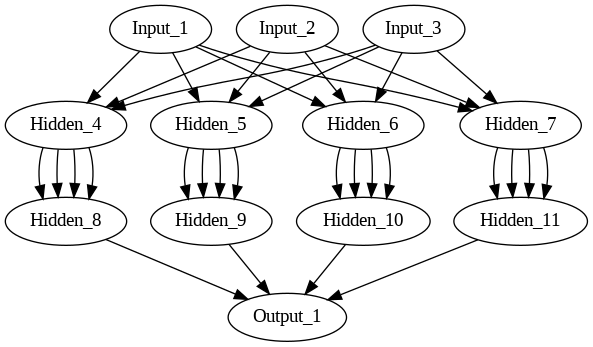

In [51]:
from graphviz import Digraph
from IPython.display import Image, display

def create_neural_network_diagram(input_dim, hidden_layers, output_dim):
    dot = Digraph(comment='Neural Network')

    # Add input layer
    for i in range(input_dim):
        dot.node(f'Input_{i+1}', f'Input_{i+1}')

    # Add hidden layers
    layer_start = input_dim + 1
    for layer_idx, layer_size in enumerate(hidden_layers):
        for i in range(layer_size):
            dot.node(f'Hidden_{layer_start + i}', f'Hidden_{layer_start + i}')
            # Connect previous layer to current hidden layer
            if layer_idx == 0:
                for j in range(input_dim):
                    dot.edge(f'Input_{j+1}', f'Hidden_{layer_start + i}')
            else:
                for j in range(hidden_layers[layer_idx - 1]):
                    dot.edge(f'Hidden_{layer_start + i - hidden_layers[layer_idx - 1]}', f'Hidden_{layer_start + i}')
        layer_start += layer_size

    # Add output layer
    output_start = layer_start
    for i in range(output_dim):
        dot.node(f'Output_{i+1}', f'Output_{i+1}')
        # Connect last hidden layer to output layer
        for j in range(hidden_layers[-1]):
            dot.edge(f'Hidden_{output_start - hidden_layers[-1] + j}', f'Output_{i+1}')

    # Render the graph to a file
    filename = 'neural_network_architecture'
    dot.render(filename, format='png', view=False)

    # Display the image directly in Jupyter Notebook or other IPython environments
    display(Image(filename=f'{filename}.png'))


create_neural_network_diagram(3, [4, 4], 1)


# Box and Wiskers Plot

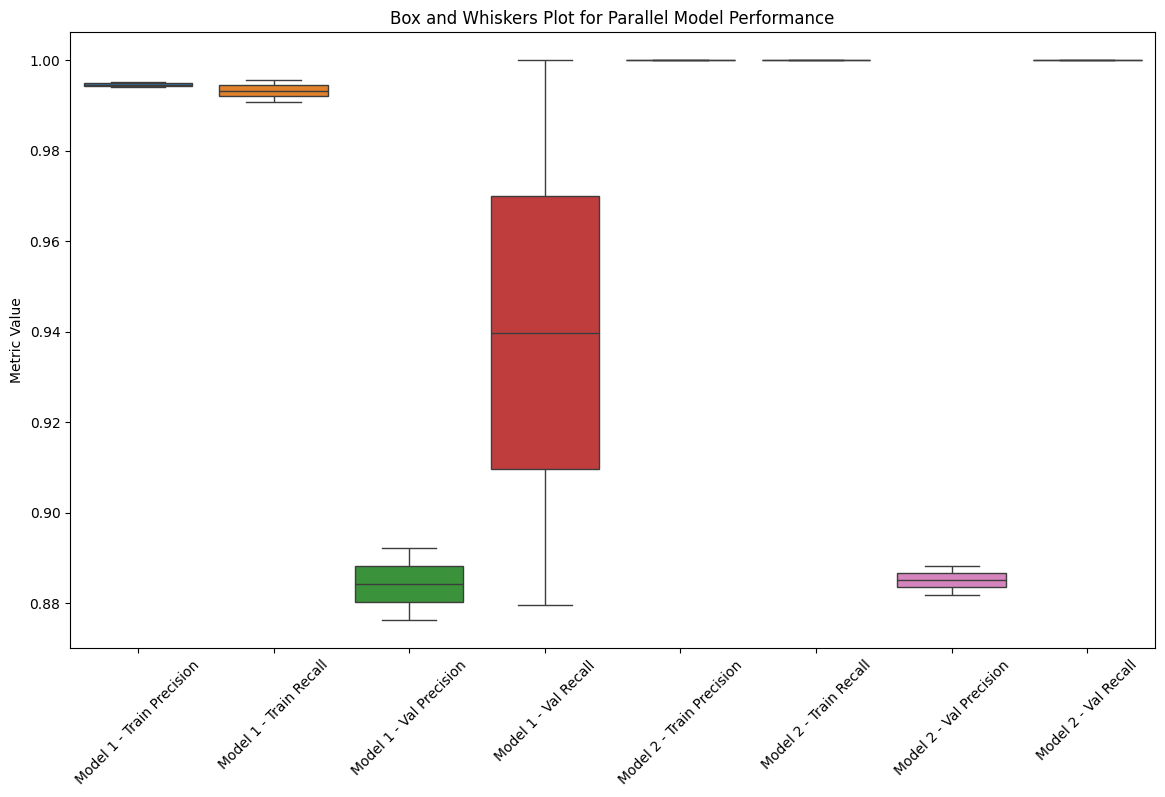

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Metrics for each model (over 2 epochs)
model_1_train_precision = [0.9952, 0.9940]
model_1_train_recall = [0.9908, 0.9957]
model_1_val_precision = [0.8762, 0.8921]
model_1_val_recall = [0.8796, 1.00]

model_2_train_precision = [1.00, 1.00]
model_2_train_recall = [1.00, 1.00]
model_2_val_precision = [0.8882, 0.8819]
model_2_val_recall = [1.00, 1.00]


# Combine the data for each model into a dictionary
metrics_data = {
    'Model 1 - Train Precision': model_1_train_precision,
    'Model 1 - Train Recall': model_1_train_recall,
    'Model 1 - Val Precision': model_1_val_precision,
    'Model 1 - Val Recall': model_1_val_recall,

    'Model 2 - Train Precision': model_2_train_precision,
    'Model 2 - Train Recall': model_2_train_recall,
    'Model 2 - Val Precision': model_2_val_precision,
    'Model 2 - Val Recall': model_2_val_recall,
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(metrics_data)

# Create the box plot
plt.figure(figsize=(14, 8))
sns.boxplot(data=df)

# Set plot labels and title
plt.title('Box and Whiskers Plot for Parallel Model Performance')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.show()




In [ ]:
Epoch [1/2], Train Loss: 0.0002, Train Acc: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Val Loss: 0.4641, Val Acc: 92.68%, Val Precision: 0.8882, Val Recall: 1.0000
Epoch [2/2], Train Loss: 0.0002, Train Acc: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Val Loss: 0.4542, Val Acc: 92.07%, Val Precision: 0.8819, Val Recall: 1.0000


# Weighted IoU

In [53]:
import torch

def weighted_iou(y_true, y_pred, class_weights=None):
    """
    Calculate the weighted Intersection over Union (IoU) for a binary classification problem.

    Args:
        y_true (torch.Tensor): Ground truth labels (1D tensor of binary values).
        y_pred (torch.Tensor): Predicted labels (1D tensor of binary values).
        class_weights (dict): Optional class weights. Default is None.
                             Example: {'positive': 1.5, 'negative': 1.0}

    Returns:
        float: Weighted IoU value.
    """
    # Ensure that the ground truth and predictions are in the same format (e.g., 0 or 1)
    y_true = y_true.float()
    y_pred = y_pred.float()

    # Calculate true positives, false positives, and false negatives
    TP = torch.sum((y_true == 1) & (y_pred == 1)).item()
    FP = torch.sum((y_true == 0) & (y_pred == 1)).item()
    FN = torch.sum((y_true == 1) & (y_pred == 0)).item()
    TN = torch.sum((y_true == 0) & (y_pred == 0)).item()

    # IoU for positive class (Parkinson's)
    iou_positive = TP / (TP + FP + FN) if (TP + FP + FN) != 0 else 0

    # IoU for negative class (Non-Parkinson's)
    iou_negative = TN / (TN + FP + FN) if (TN + FP + FN) != 0 else 0

    # Default weights for positive and negative classes
    weights = {'positive': 1.0, 'negative': 1.0}

    if class_weights:
        weights = class_weights

    # Weighted IoU: Weighted average of both classes' IoU
    weighted_iou = (weights['positive'] * iou_positive + weights['negative'] * iou_negative) / \
                   (weights['positive'] + weights['negative'])

    return weighted_iou


y_true = torch.tensor([1, 0, 1, 0, 1, 0, 1, 1])  # Ground truth
y_pred = torch.tensor([1, 0, 1, 0, 0, 0, 1, 1])  # Predictions

# Define class weights
class_weights = {'positive': 1.5, 'negative': 1.0}  # You can adjust weights as needed

# Calculate weighted IoU
iou_value = weighted_iou(y_true, y_pred, class_weights)
print(f"Weighted IoU: {iou_value:.4f}")


Weighted IoU: 0.7800


# RoC curve

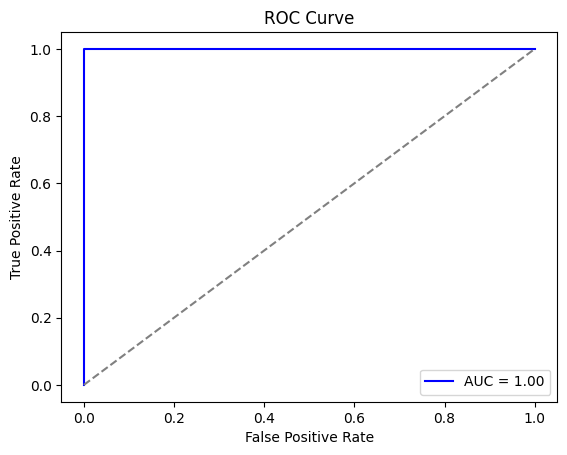

In [54]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true = labels_batch.cpu().numpy()
y_pred = predicted.cpu().numpy()
fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_value = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_value:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


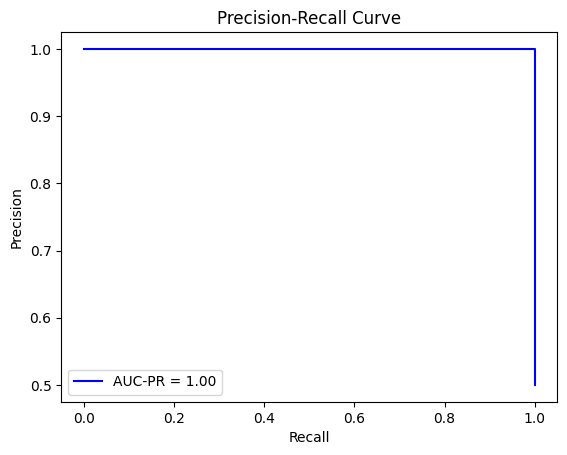

In [55]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(y_true, y_pred)
auc_pr = average_precision_score(y_true, y_pred)

plt.plot(recall, precision, color='blue', label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


# Class Distribution

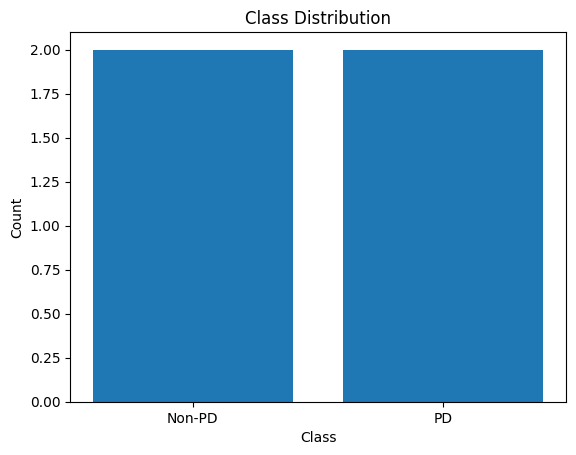

In [57]:
import numpy as np
import matplotlib.pyplot as plt


unique, counts = np.unique(y_true, return_counts=True)
plt.bar(unique, counts, tick_label=['Non-PD', 'PD'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()
